# Step 1: Introduction

## 1.1 Import libraries

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp
from sklearn.model_selection import KFold, GridSearchCV,  StratifiedKFold, RepeatedStratifiedKFold, cross_val_score, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,f1_score, recall_score, classification_report
from sklearn.metrics import roc_auc_score, confusion_matrix
import time
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.2f}'.format

## 1.2 Description about dataset

In [32]:
# import dataset
df = pd.read_csv("heart.csv")

* **Age**: age of the patient [years]
* **Sex**: sex of the patient [M: Male, F: Female]
* **ChestPainType**: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
* **RestingBP**: resting blood pressure [mm Hg]
* **Cholesterol**: serum cholesterol [mm/dl]
* **FastingBS**: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
* **RestingECG**: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
* **MaxHR**: maximum heart rate achieved [Numeric value between 60 and 202]
* **ExerciseAngina**: exercise-induced angina [Y: Yes, N: No]
* **Oldpeak**: oldpeak = ST [Numeric value measured in depression]
* **ST_Slope**: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
* **HeartDisease**: output class [1: heart disease, 0: Normal]

In [33]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.00,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.00,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.00,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.50,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.00,Up,0


In [34]:
df.shape

(918, 12)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [36]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.00,918.00,918.00,918.00,918.00,918.00,918.00
mean,53.51,132.40,198.80,0.23,136.81,0.89,0.55
std,9.43,18.51,109.38,0.42,25.46,1.07,0.50
min,28.00,0.00,0.00,0.00,60.00,-2.60,0.00
25%,47.00,120.00,173.25,0.00,120.00,0.00,0.00
50%,54.00,130.00,223.00,0.00,138.00,0.60,1.00
75%,60.00,140.00,267.00,0.00,156.00,1.50,1.00
max,77.00,200.00,603.00,1.00,202.00,6.20,1.00


In [37]:
df.describe(include = 'O')

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
count,918,918,918,918,918
unique,2,4,3,2,3
top,M,ASY,Normal,N,Flat
freq,725,496,552,547,460


In [38]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

## 1.3 Visualization


In [39]:
# Overall about output of database
partition = list(df['HeartDisease'].value_counts())

fig = go.Figure(data=[go.Pie(labels=['Normal','Heart Disease'],
                             values=partition,
                             hole=.3, # this creates a "donut" style pie chart
                             pull=[0.1, 0], # this "explodes" the 'Normal' slice
                             )])

fig.update_layout(title_text='Heart Disease %')

fig.show()

In [40]:
numerical_values=df[['Age', 'RestingECG', 'Cholesterol', 'MaxHR', 'Oldpeak']]
categorical_values=df[['Sex', 'ChestPainType','FastingBS', 'RestingECG', 'ExerciseAngina','ST_Slope', 'HeartDisease']]

In [41]:
category=list(categorical_values)
numerical= list(numerical_values)

In [42]:
#Impact of Categorical Features on the output
fig = sp.make_subplots(rows=1, cols=6)

color= ['#ADD8E6','#E0FFFF']

for i in range(len(category) - 1):
    data = categorical_values[category[i]].value_counts().reset_index()
    data.columns = [category[i], 'count']
    fig.add_trace(go.Bar(x=data[category[i]], y=data['count'], 
                         marker_color=color, name=category[i]), 
                  row=1, col=i+1)

fig.update_layout(title_text='Impact of Categorical Features on the output')

fig.show()

In [43]:
fig = px.histogram(df, x="Age", color="HeartDisease", nbins=30, 
                   title="Distribution of Heart Diseases over Age", 
                   color_discrete_sequence=px.colors.qualitative.Safe)
fig.show()

In [44]:
px.histogram(data_frame = df, x = 'Sex', color = 'HeartDisease', title="Distribution of Heart Diseases over Sex",barmode="group")

In [45]:
fig = px.histogram(df, x="RestingECG", color="HeartDisease", nbins=30, 
                   title="Distribution of Heart Diseases over RestingECG", 
                   color_discrete_sequence=px.colors.qualitative.Set1)
fig.show()

In [46]:
px.histogram(data_frame = df, x = 'ChestPainType', color = 'HeartDisease', title="Distribution of Heart Diseases over ChestPainType",barmode="group")

[]

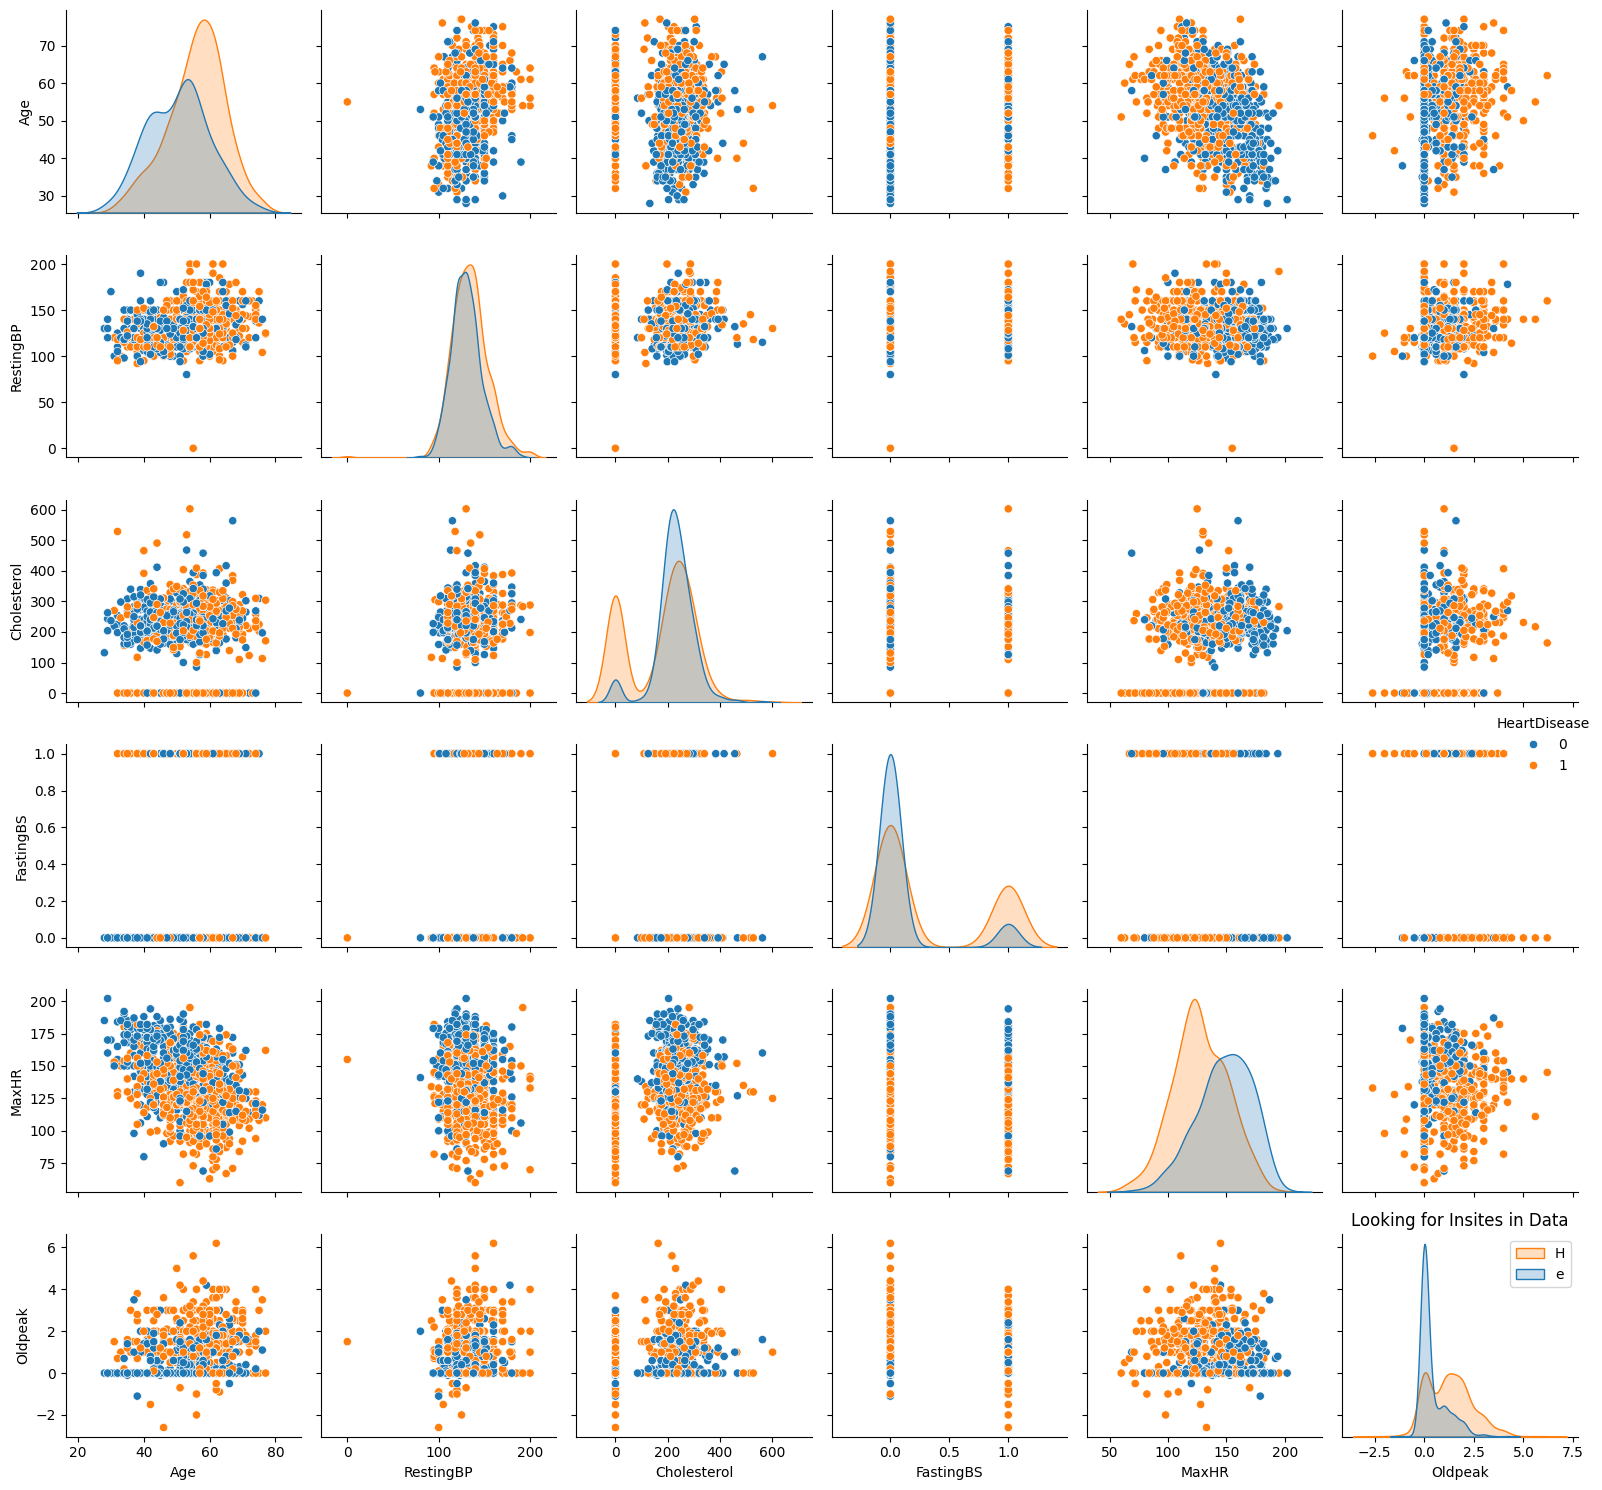

In [47]:
sns.pairplot(df,hue="HeartDisease")
plt.title("Looking for Insites in Data")
plt.legend("HeartDisease")
plt.tight_layout()
plt.plot()

In [48]:
fig = sp.make_subplots(rows=4, cols=3)

for i, col in enumerate(df.columns, 1):
    fig.add_trace(go.Histogram(x=df[col], nbinsx=30, name=col), 
                  row=(i-1)//3+1, col=(i-1)%3+1)

fig.update_layout(height=800, width=1200, title_text="Distribution of Data")
fig.show()

In [49]:
fig = px.box(df,y="RestingBP",x="HeartDisease",title=f"Distrubution of RestingBP")
fig.show()

In [50]:
fig = px.box(df,y="Age",x="HeartDisease",title=f"Distrubution of Age",color="Sex")
fig.show()

In [51]:
fig = px.box(df,y="Cholesterol",x="HeartDisease",title=f"Distrubution of Cholesterol",color="Sex")
fig.show()

In [52]:
fig = px.box(df,y="Oldpeak",x="HeartDisease",title=f"Distrubution of Oldpeak")
fig.show()

In [53]:
fig = px.box(df,y="MaxHR",x="HeartDisease",title=f"Distrubution of MaxHR",color="Sex")
fig.show()

# Step 2. Preprocessing

In [54]:
data = pd.get_dummies(df,columns=['Sex','ChestPainType','RestingECG','ExerciseAngina','ST_Slope'],drop_first=True)
data.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.00,0,True,True,False,False,True,False,False,False,True
1,49,160,180,0,156,1.00,1,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.00,0,True,True,False,False,False,True,False,False,True
3,48,138,214,0,108,1.50,1,False,False,False,False,True,False,True,True,False
4,54,150,195,0,122,0.00,0,True,False,True,False,True,False,False,False,True


In [55]:
data = data.astype(int)
data.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0,0,1,1,0,0,1,0,0,0,1
1,49,160,180,0,156,1,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0,0,1,1,0,0,0,1,0,0,1
3,48,138,214,0,108,1,1,0,0,0,0,1,0,1,1,0
4,54,150,195,0,122,0,0,1,0,1,0,1,0,0,0,1


In [56]:
split_index = int(data.shape[0] * 0.9) 

data1 = data.iloc[:split_index, :]  
data2 = data.iloc[split_index:, :]

In [57]:
data1.shape, data.shape

((826, 16), (918, 16))

<Axes: >

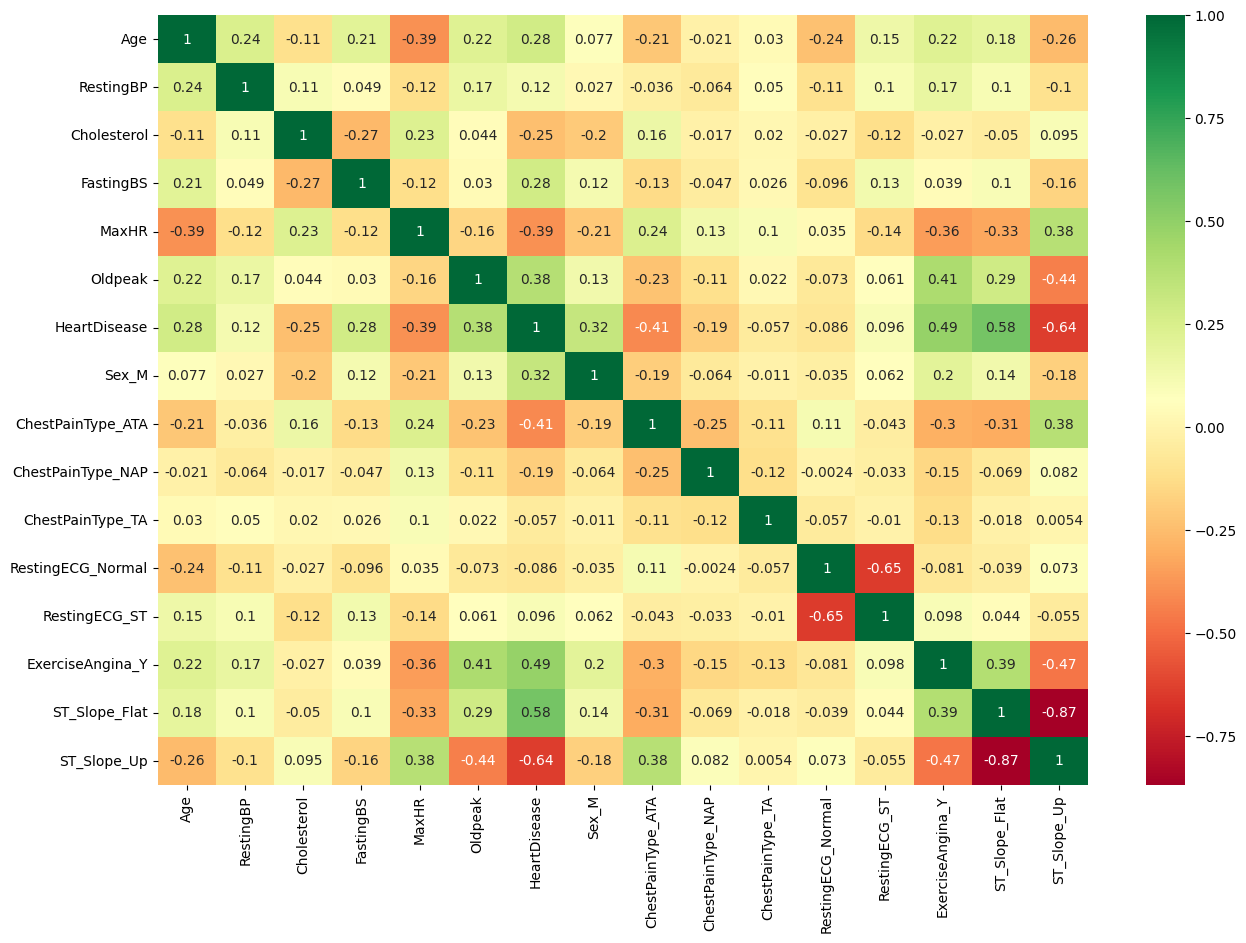

In [58]:
plt.figure(figsize=(15,10))
sns.heatmap(data1.corr(),annot=True,cmap='RdYlGn')

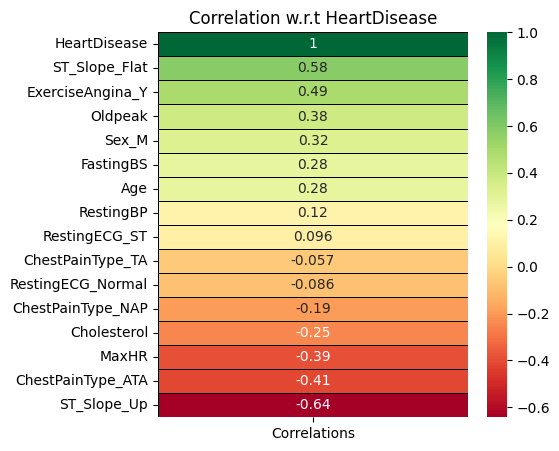

In [59]:
corr = data1.corrwith(data['HeartDisease']).sort_values(ascending = False).to_frame()
corr.columns = ['Correlations']
plt.subplots(figsize = (5,5))
sns.heatmap(corr,annot = True,cmap= 'RdYlGn',linewidths = 0.4,linecolor = 'black');
plt.title('Correlation w.r.t HeartDisease');

In [60]:
X = data1.drop(['HeartDisease'],axis=1)
y = data1['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [61]:
numerical_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR']
from sklearn.preprocessing import MinMaxScaler, StandardScaler
normalize= MinMaxScaler()
standard= StandardScaler()
X_train['Oldpeak']= normalize.fit_transform(X_train[['Oldpeak']])
X_train[numerical_features]= standard.fit_transform(X_train[numerical_features])

In [62]:
X_test[numerical_features]= standard.transform(X_test[numerical_features])
X_test['Oldpeak']= normalize.transform(X_test[['Oldpeak']])

# Step 3 : Grid Search - Applying & comparing & choosing best model 

In [63]:
# Define the models and their parameters
models_params = {
    'KNeighborsClassifier': (KNeighborsClassifier(), {
        'n_neighbors': [x for x in range(1,15,1)],
        'weights': ['uniform', 'distance'],
        'leaf_size': [1, 2, 3, 5, 10],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    }),
    'GaussianNB': (GaussianNB(), {
        "var_smoothing": np.logspace(0, -9, num=100)
    }),
    'SVC': (SVC(), {
        'C':[0.01, 0.1,1, 10, 15, 20],
        'gamma': [1.5,1,0.1,0.01,0.001, 0.0001],
        'kernel': ['rbf', 'poly', 'sigmoid', 'linear']
    }),
    'MLPClassifier': (MLPClassifier(), {
        'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
        'activation': ['tanh', 'relu'],
        'solver': ['sgd', 'adam'],
        'alpha': [0.0001, 0.05],
        'early_stopping': [True, False],
        'learning_rate': ['constant','adaptive'],
    }),
    'LogisticRegression': (LogisticRegression(), {
        'C': [5, 10,15],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'penalty': ['l1', 'l2', 'none']
    }),
    'RandomForestClassifier': (RandomForestClassifier(), {
        'n_estimators': np.array([50, 100, 150,200]),
        'max_depth': [3,4,5],
        'min_samples_split': [2, 5,],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
    })
}

kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Loop over the models and parameters to perform the grid search
for model_name, (model, params) in models_params.items():
    gridsearch = GridSearchCV(estimator=model, param_grid=params, scoring='accuracy', cv=kfold ,n_jobs = -1)
    gridsearch.fit(X_train, y_train)
    
    print(f'--- {model_name} ---')
    print(f'The best accuracy score for training dataset is {gridsearch.best_score_:.2%}')
    print(f'The best hyperparameters are {gridsearch.best_params_}')

    

 

--- KNeighborsClassifier ---
The best accuracy score for training dataset is 87.02%
The best hyperparameters are {'leaf_size': 1, 'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
--- GaussianNB ---
The best accuracy score for training dataset is 86.16%
The best hyperparameters are {'var_smoothing': 0.12328467394420659}
--- SVC ---
The best accuracy score for training dataset is 87.71%
The best hyperparameters are {'C': 1, 'gamma': 0.1, 'kernel': 'poly'}
--- MLPClassifier ---
The best accuracy score for training dataset is 86.68%
The best hyperparameters are {'activation': 'tanh', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'sgd'}
--- LogisticRegression ---
The best accuracy score for training dataset is 85.64%
The best hyperparameters are {'C': 5, 'penalty': 'l2', 'solver': 'lbfgs'}
--- RandomForestClassifier ---
The best accuracy score for training dataset is 87.36%
The best hyperparameters are {'c

In [64]:
X_train.shape, y_train.shape

((578, 15), (578,))

In [65]:
def classificate(classifier):
    start_time = time.time()
    
    classifier.fit(X_train, y_train)
    y_pred  = classifier.predict(X_test)
    
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test,y_pred)
    roc_auc = roc_auc_score(y_test,y_pred)
    
    cross_val_score_mean = cross_val_score(classifier, X_train, y_train, cv=cv, scoring="roc_auc").mean()
    
    end_time = time.time()
    time_taken = end_time - start_time
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    return {
        'Model': type(classifier).__name__,
        'Accuracy': accuracy,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC Score': roc_auc,
        'Cross Validation Score': cross_val_score_mean,
        'Time taken to train': time_taken
    }


In [66]:
knn = KNeighborsClassifier(leaf_size=1, metric='euclidean', n_neighbors=5, weights='uniform')
gnb = GaussianNB(var_smoothing=0.12328467394420659)
svc = SVC(C=1, gamma=0.1, kernel='poly')
mlp = MLPClassifier(activation='tanh', alpha=0.0001, early_stopping=False, hidden_layer_sizes=(50, 100, 50), learning_rate='adaptive', solver='sgd')
lr = LogisticRegression(C=5, penalty='l2', solver='lbfgs')
rf = RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=500)


--- Model 1 ---


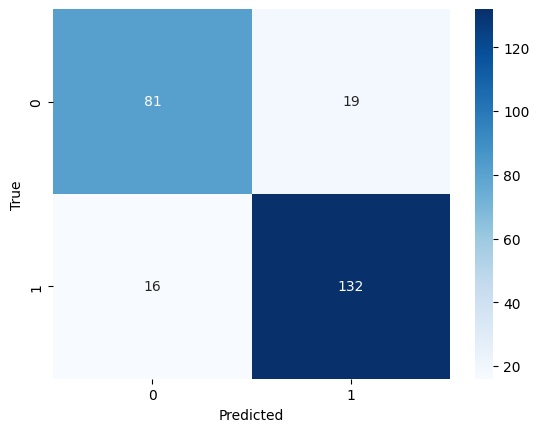

--- Model 2 ---


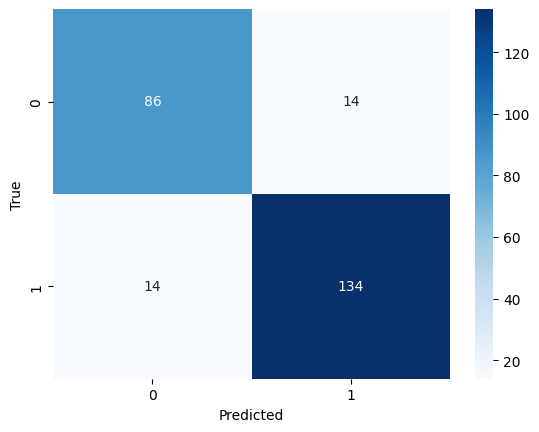

--- Model 3 ---


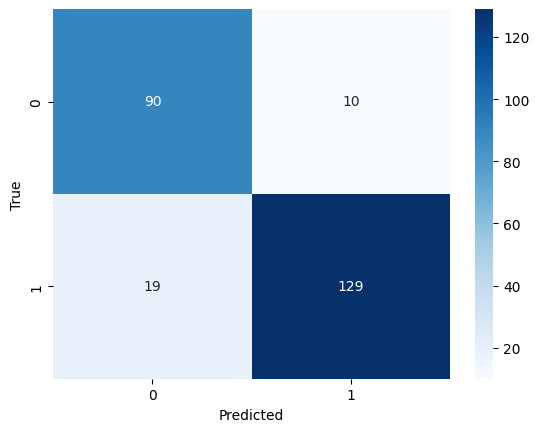

--- Model 4 ---


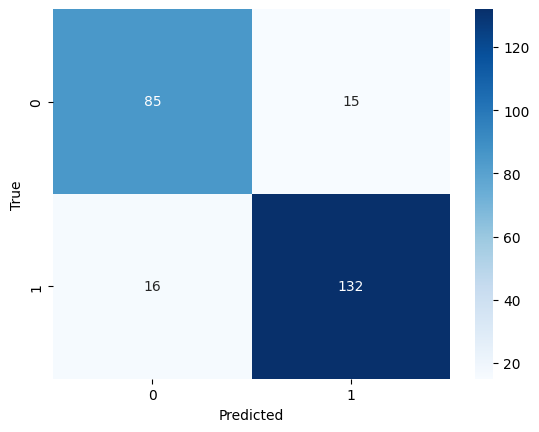

--- Model 5 ---


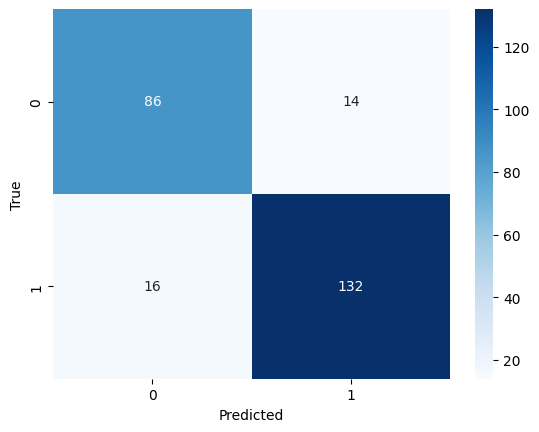

--- Model 6 ---


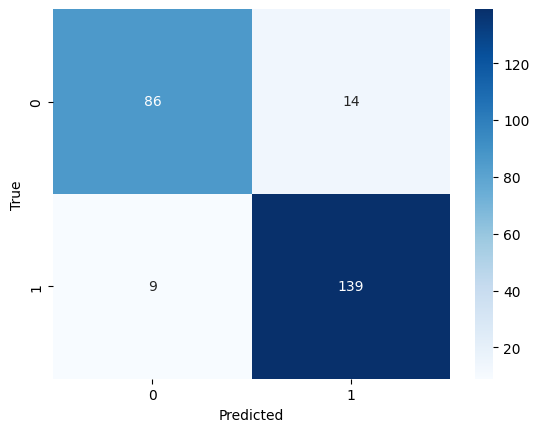

In [67]:
models = [knn, gnb, svc, mlp, lr, rf]
results = []
for i in range(len(models)):
    print(f'--- Model {i+1} ---')
    results.append(classificate(models[i]))

In [68]:
results_df = pd.DataFrame(results)
results_df

,Model,Accuracy,Recall,F1 Score,ROC AUC Score,Cross Validation Score,Time taken to train
0,KNeighborsClassifier,0.86,0.89,0.88,0.85,0.91,0.27
1,GaussianNB,0.89,0.91,0.91,0.88,0.92,0.09
2,SVC,0.88,0.87,0.90,0.89,0.92,0.15
3,MLPClassifier,0.88,0.89,0.89,0.87,0.92,18.73
4,LogisticRegression,0.88,0.89,0.90,0.88,0.92,0.12
5,RandomForestClassifier,0.91,0.94,0.92,0.90,0.92,8.14


In [69]:
# # save the models for all trained models
# import joblib
# for i in range(len(models)):
#     joblib.dump(models[i], f'model_{i}.pkl')
    

# Step 4: Exited model